In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model
from fastai.vision.all import *
set_seed(999, reproducible=True)
BATCH_SIZE = 8                       
dataset_path = Path('../input/petfinder-pawpularity-score/')
dataset_path.ls()
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [2]:
n_models=3
batch_models=[32,24,24] #batch for swin_224,vision_224,swin_384
image_siz=[224,384,384]  #image_size for swin_224,vision_224,swin_384
input_path='../input/transformer-ensemble/model_'
models_path=['swin_','swin_384_0','swin_384_']
model_folds=[10,4,8]
req_features=[]

In [3]:
image_siz[0]

224

In [4]:
test_df = pd.read_csv(dataset_path/'test.csv')
new_df=pd.DataFrame()
new_test_df=pd.DataFrame()
new_test_df.index=test_df.Id


In [5]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.sample(frac=1).reset_index(drop=True)
new_df['Pawpularity']=train_df['Pawpularity']/100
new_df['Id']=train_df.Id
train_df = train_df.drop(columns=['Id'])
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,0,1,1,0,0,0,0,0,0,0,1,50,../input/petfinder-pawpularity-score/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,0,1,1,1,0,1,0,1,0,0,1,0,25,../input/petfinder-pawpularity-score/train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,0,0,1,1,0,1,0,0,0,0,0,0,27,../input/petfinder-pawpularity-score/train/6548166fb3fda22b67881176397f0223.jpg
3,0,1,1,1,0,0,0,0,1,1,0,0,19,../input/petfinder-pawpularity-score/train/472c40116e1833555715e4774445ae5b.jpg
4,0,1,1,1,0,0,0,1,0,0,0,0,27,../input/petfinder-pawpularity-score/train/7b77e1a6d93667b575d57db83facd860.jpg


The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
960 960


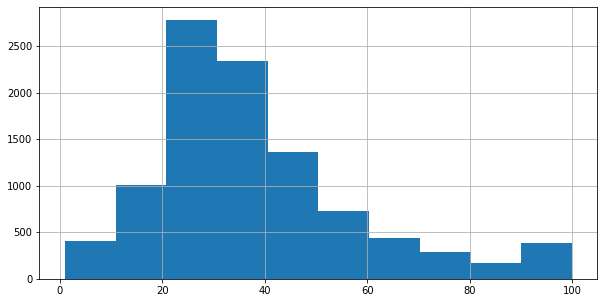

In [6]:
len_df = len(train_df)
train_df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")

train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']
im = Image.open(train_df['path'][1])
train_df_copy=train_df.copy()
width, height = im.size
print(width,height)

In [7]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

In [8]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [9]:
# num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
# train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
# train_df['bins'].hist()

In [10]:
# from sklearn.model_selection import KFold
# from sklearn.model_selection import StratifiedKFold

# train_df['fold'] = -1

# N_FOLDS = 5
# strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
# for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
#     train_df.iloc[train_index, -1] = i
    
# train_df['fold'] = train_df['fold'].astype('int')
# train_df.fold.value_counts().plot.bar()

In [11]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
def process_data(model_num,train_df):
    num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
    train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
    train_df['bins'].hist()
    train_df['fold'] = -1
    N_FOLDS = model_folds[model_num]
    strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
    for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
        train_df.iloc[train_index, -1] = i
    train_df['fold'] = train_df['fold'].astype('int')
    test_df = pd.read_csv(dataset_path/'test.csv')
    test_df['Pawpularity'] = [1]*len(test_df)
    test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
    test_df = test_df.drop(columns=['Id'])
    test_df['norm_score'] = test_df['Pawpularity']/100
    return [train_df,test_df]

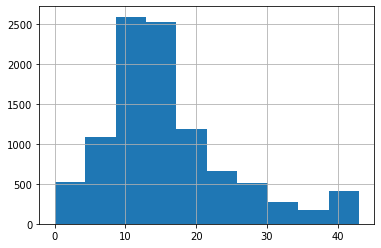

In [12]:
train_df,test_df=process_data(0,train_df_copy)

In [13]:
def get_data(fold,vl):
    train_df_f = train_df.copy()
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    dls = ImageDataLoaders.from_df(train_df_f,
                               valid_col='is_valid',
                               seed=999,
                               fn_col='path',
                               label_col='norm_score',
                               y_block=RegressionBlock,
                               bs=batch_models[vl], 
                               num_workers=8, 
                               item_tfms=Resize(image_siz[vl]), 
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    
    return dls

In [14]:
train_df

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,norm_score,bins,fold
0,0,0,1,1,0,0,0,0,0,0,0,1,50,../input/petfinder-pawpularity-score/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg,0.50,21,9
1,0,1,1,1,0,1,0,1,0,0,1,0,25,../input/petfinder-pawpularity-score/train/25e3bf4267c2dc3f579b779418221bb7.jpg,0.25,10,8
2,0,0,1,1,0,1,0,0,0,0,0,0,27,../input/petfinder-pawpularity-score/train/6548166fb3fda22b67881176397f0223.jpg,0.27,11,6
3,0,1,1,1,0,0,0,0,1,1,0,0,19,../input/petfinder-pawpularity-score/train/472c40116e1833555715e4774445ae5b.jpg,0.19,7,9
4,0,1,1,1,0,0,0,1,0,0,0,0,27,../input/petfinder-pawpularity-score/train/7b77e1a6d93667b575d57db83facd860.jpg,0.27,11,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,0,1,1,1,0,0,0,0,0,0,0,0,26,../input/petfinder-pawpularity-score/train/d9a59cf5f9b386ca222cdc348335c143.jpg,0.26,11,8
9908,0,1,1,1,0,0,0,0,0,0,0,0,65,../input/petfinder-pawpularity-score/train/c3ae20e7de8c74a62a37166bb57f4e2e.jpg,0.65,28,8
9909,0,1,1,0,0,0,0,0,1,1,0,0,38,../input/petfinder-pawpularity-score/train/d9ea120ce5d5213ba2dc31b23de439e6.jpg,0.38,16,8
9910,0,1,1,1,0,0,0,0,0,0,0,0,44,../input/petfinder-pawpularity-score/train/9714de78407cc26d1ecbdcae534e1cee.jpg,0.44,19,6


In [15]:
the_data = get_data(0,0)
print()
assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//batch_models[0])

In [16]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [17]:
from fastai.vision.all import *
mixup = MixUp(1.)

In [18]:
def get_learner(fold_num,model,j):
    data = get_data(fold_num,j)
    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(),cbs=mixup,metrics=petfinder_rmse).to_fp16()
    return learn

In [19]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
test_df['norm_score'] = test_df['Pawpularity']/100

In [20]:
import gc

In [21]:
all_preds=[]
for j in range(n_models):
#     train_df,test_df=process_data(j,train_df_copy)
    if j==1 :
        continue
    for i in range(model_folds[j]):
        print(f'Fold {i} of model {models_path[j]} results')
        model=torch.load(input_path+models_path[j]+str(i)+".pt")
        learn = get_learner(i,model,j)
        dls = ImageDataLoaders.from_df(train_df,
                               valid_pct=0.2,
                               seed=999,  
                               fn_col='path', 
                               label_col='norm_score', 
                               y_block=RegressionBlock,
                               bs=batch_models[j], 
                               num_workers=8,
                               item_tfms=Resize(image_siz[j]),
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
        test_dl = dls.test_dl(test_df)
        preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
        new_test_df[models_path[j]+"_pred"+str(i)]=preds
        all_preds.append(preds)
#         test_dl = dls.test_dl(train_df)
#         preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
#         new_df[model_path[j]+"_pred"+str(i)]=preds
        req_features.append(models_path[j]+"_pred"+str(i))
        del learn
        torch.cuda.empty_cache()
        gc.collect()
        
        

Fold 0 of model swin_ results


Fold 1 of model swin_ results


Fold 2 of model swin_ results


Fold 3 of model swin_ results


Fold 4 of model swin_ results


Fold 5 of model swin_ results


Fold 6 of model swin_ results


Fold 7 of model swin_ results


Fold 8 of model swin_ results


Fold 9 of model swin_ results


Fold 0 of model swin_384_ results


Fold 1 of model swin_384_ results


Fold 2 of model swin_384_ results


Fold 3 of model swin_384_ results


Fold 4 of model swin_384_ results


Fold 5 of model swin_384_ results


Fold 6 of model swin_384_ results


Fold 7 of model swin_384_ results


In [22]:
for i in range(1,5):
        j=1
        print(f'Fold {i} of model {models_path[j]} results')
        model=torch.load(input_path+models_path[j]+str(i)+".pt")
        learn = get_learner(i,model,j)
        dls = ImageDataLoaders.from_df(train_df,
                               valid_pct=0.2,
                               seed=999,  
                               fn_col='path', 
                               label_col='norm_score', 
                               y_block=RegressionBlock,
                               bs=batch_models[j], 
                               num_workers=8,
                               item_tfms=Resize(image_siz[j]),
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
        test_dl = dls.test_dl(test_df)
        preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
        new_test_df[models_path[j]+"_pred"+str(i)]=preds
        all_preds.append(preds)
#         test_dl = dls.test_dl(train_df)
#         preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
#         new_df[model_path[j]+"_pred"+str(i)]=preds
        req_features.append(models_path[j]+"_pred"+str(i))
        del learn
        torch.cuda.empty_cache()
        gc.collect()

Fold 1 of model swin_384_0 results


Fold 2 of model swin_384_0 results


Fold 3 of model swin_384_0 results


Fold 4 of model swin_384_0 results


In [23]:
new_test_df.to_csv("final_test_preds.csv")

In [24]:
new_test_df

,swin__pred0,swin__pred1,swin__pred2,swin__pred3,swin__pred4,swin__pred5,swin__pred6,swin__pred7,swin__pred8,swin__pred9,...,swin_384__pred2,swin_384__pred3,swin_384__pred4,swin_384__pred5,swin_384__pred6,swin_384__pred7,swin_384_0_pred1,swin_384_0_pred2,swin_384_0_pred3,swin_384_0_pred4
Id,,,,,,,,,,,,,,,,,,,,,
4128bae22183829d2b5fea10effdb0c3,0.447957,0.415262,0.416437,0.359511,0.394780,0.370828,0.419108,0.407015,0.426900,0.390452,...,0.414687,0.428617,0.424397,0.399564,0.407617,0.375801,0.425295,0.409174,0.387748,0.420719
43a2262d7738e3d420d453815151079e,0.449145,0.430499,0.422903,0.380744,0.403764,0.381705,0.422541,0.414864,0.429981,0.408601,...,0.418174,0.430973,0.430567,0.410044,0.424380,0.384201,0.433288,0.420840,0.400471,0.423923
4e429cead1848a298432a0acad014c9d,0.450935,0.408729,0.418252,0.353602,0.402116,0.375619,0.418000,0.406502,0.426466,0.388175,...,0.417569,0.430423,0.428235,0.397104,0.411398,0.375622,0.429830,0.415559,0.396517,0.424115
80bc3ccafcc51b66303c2c263aa38486,0.451254,0.420857,0.425835,0.372148,0.416320,0.384440,0.423924,0.413869,0.431837,0.406067,...,0.417260,0.431058,0.431214,0.399192,0.419319,0.378557,0.432714,0.419582,0.399660,0.425367
8f49844c382931444e68dffbe20228f4,0.452084,0.405943,0.417642,0.362720,0.406937,0.366779,0.421578,0.405534,0.425694,0.389036,...,0.417521,0.428927,0.426107,0.393485,0.414432,0.376338,0.426160,0.414676,0.393130,0.421969
b03f7041962238a7c9d6537e22f9b017,0.454775,0.412906,0.424055,0.379382,0.412049,0.368917,0.423363,0.409387,0.427720,0.396657,...,0.415693,0.429358,0.421923,0.394215,0.416124,0.373650,0.427973,0.415173,0.392776,0.421278
c978013571258ed6d4637f6e8cc9d6a3,0.451805,0.416615,0.423227,0.365817,0.413158,0.376523,0.422686,0.408776,0.434186,0.394527,...,0.416370,0.430459,0.428237,0.401472,0.422251,0.381137,0.428501,0.416852,0.395536,0.423244
e0de453c1bffc20c22b072b34b54e50f,0.450143,0.419365,0.419271,0.368345,0.410577,0.381477,0.420150,0.412912,0.430941,0.398307,...,0.416845,0.428281,0.428007,0.401560,0.416582,0.380720,0.426290,0.414335,0.392689,0.423530


In [25]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
preds = np.mean(np.stack(all_preds), axis=0)
sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)

In [26]:
preds

array([[0.40517843],
       [0.4139191 ],
       [0.40678254],
       [0.41301033],
       [0.40622395],
       [0.40834105],
       [0.410459  ],
       [0.40979853]], dtype=float32)